<a href="https://colab.research.google.com/github/Julian-Banks/EEE4022S_BNKJUL001_Thesis/blob/main/PythonWorkspace/EMSv1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Version Notes**

# **v1.1**

**Added:**
* rect and inverter power tracking
* reward logging in my own logging func
* changed logging vars to arrays
*

**To Do**

* battery charging rates - I think my assumption is fine.

* tweak visualisation to show bar graphs at the end of training/testing. Maybe just print graphs at the end? I have added plt.show() - remember to play if it doesnt work!

* impliment a generator!!!!!
* impliment a priority load

* NB figure out how to have more episodes!! I think it will have big performance boosts on the training :)

* thinking that maybe I should change obs space back to what it was cause I dont actully need to know individual loads and gens!!!!

# **v1.0**

**Added:**
* AC and DC load
* Wind Gen
* changed obs space to hold new loads
* re wrote standby and purchase functions

**To DO**
* thinking that maybe I should change obs space back to what it was cause I dont actully need to know individual loads and gens!!!!
* Add in rectifier & inverter power tracking
* battery charging rates


# **v0.3**
**Added:**
* loadshedding
* New reward structure
* added Vec_env
* added eval callbacks to validate training
* added in logging

**Parameters:**
* Added in loadshedding forecast

**To do:**
* find out about battery charging rates  & impliment
* Find out if I need to normalise
* Try dqn
* Find out how the bounds for the obs_space box effect things
* Try play with DummyVec wrapper (didnt work in last version)

# **v0.2_1**
**Added:**
*  Monitor wrapper
*  DummyVec wrapper
*  Wand (weights and bais) enabled

**Parameters:**
* lowered to 3 predictions  

**To do:**
* Try to use hyperparameter Optimisation - decided Im only going to do on the final version
* Try normalise
* Try differnet models
* Find out how the bounds for the obs_space box effect things

# **v0.2**
**Added:**
*  simplified load_forecast and gen_forecast to be power_bal_forecasts.
*  combined current_load and current_gen to also show current_power_balance
*  added proper evaluate call

**Parameters:**
* No changes  

**Results:**
* 5% savings on PPO deterministic = true
* 4.3% savings on PPO determnistic = false

**To do:**
* Try to use hyperparameter Optimisation
* Try normalise
* Try differnet models
* Try see if discount rate can be tweaked - at good level.
* Find out how the bounds for the obs_space box effect things

# **v0.1**
**Added:**
* added real loads, gen, tou_id's

**Parameters:**
* training episode = 6000 timesteps
* testing episode  = 2760 timesteps
* bat_threshold = 100
* bat_cap = 500
* battery_level at reset = bat_cap/2
* num_preds = 24
* Trained PPO for 1.65mil timesteps
* Trained A2C for 1.2 mil timesteps

**Results:**
* PP0 - 3.7% improvement from standby mode Deterministic = False
* PPO - 6.1% Deterministic =  True
* A2C  - -0.3% improvement. And the models after this got worse as training progressed!
**To do:**
* Try lower num_preds
* Try to use hyperparameter Optimisation
* Try normalise
* Try differnet models
* Try see if discount rate can be tweaked




In [23]:
%%capture
#install dependancies
!pip install gymnasium
!pip install stable_baselines3[extra]
!pip install wandb
%load_ext tensorboard

#clone repository
! git clone https://github.com/Julian-Banks/EEE4022S_BNKJUL001_Thesis

#to update the rep
%cd /content/EEE4022S_BNKJUL001_Thesis
! git pull
#import needed libarys
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces
import datetime
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecVideoRecorder
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from gym.wrappers import FlattenObservation


from google.colab import drive
import os
import wandb
from wandb.integration.sb3 import WandbCallback
from gymnasium.envs.registration import register



#mount the drive
drive.mount('/content/drive')
#define paths to logs and model saves
model_type = "PPO_2"
version    = "EMSv1_1"
model_dir = f"/content/drive/MyDrive/Colab Notebooks/{version}/models/{model_type}/"
log_dir   = f"/content/drive/MyDrive/Colab Notebooks/{version}/models/{model_type}logs/"
animation_dir = f"/content/drive/MyDrive/Colab Notebooks/{version}/models/{model_type}/animation/"

#make the appropriate directory if it does not exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(animation_dir):
    os.makedirs(animation_dir)


**Define our environment class!!**

In [27]:
class EMSv1_1(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human","rgb_array"], "render_fps": 30}

    def __init__(self,bat_threshold = 0.1, bat_cap = 1, actual_load = "none", actual_gen = "none", purchase_price = [1,1,1,1,1,1,1,1,2,2,2,2] , episode_len = 8760,num_preds = 24,render_mode = "rgb_array", load_shedding = "none", wandb_log = False,train_log = True):

        super(EMSv1_1, self).__init__()
        #define render_mode
        self.render_mode = render_mode
        #define wandb
        self.wandb_log = wandb_log
        self.train_log = train_log
        #define time frame
        self.current_step = 0
        self.final_step = int(episode_len)-num_preds-2 #one years worth of steps

        #Might make a function for these
        #fill all of the actual loads NB!!! is just random for now NB!!! is normalised 0-1
        if isinstance(actual_load,str) :
            self.actual_load = np.random.rand(self.final_step+num_preds+1,2).astype(np.float32) #will load from a file or something
        else:
           self.actual_load  = actual_load[:episode_len,:]

        #fill all of the actual generation steps.
        if isinstance(actual_gen,str):
            self.actual_gen  = np.random.rand(self.final_step+num_preds+1,2).astype(np.float32) #will load from file or something
        else:
            self.actual_gen  = actual_gen[:episode_len,:]

        #Fill the loadShedding indicator
        if isinstance(load_shedding,str):
            num_shedding   = np.random.randint(int(0.02*episode_len), int(0.05*episode_len))
            load_shed      = np.array([1]*num_shedding + [0]*(episode_len - num_shedding))
            np.random.shuffle(load_shed)
            self.load_shed = load_shed
        else:
            self.load_shed = load_shedding[:episode_len]

        #define vars for render
        self.off_peak_purchases = np.zeros(self.final_step)
        self.standard_purchases = np.zeros(self.final_step)
        self.peak_purchases     = np.zeros(self.final_step)

        self.off_peak_num       = 0
        self.peak_num           = 0
        self.standard           = 0

        self.unmet_load_total   = 0
        self.frames = []

        #Define a var for unmet load no that there is loadshedding
        self.step_unmet_load = np.zeros(self.final_step)

        #define the purchase price for every step of the year
        purchase_price = np.array(purchase_price).astype(np.float32)
        repetitions    = (self.final_step+num_preds+1) // len(purchase_price)
        remainder      = (self.final_step+num_preds+1) % len(purchase_price)
        self.purchase_price =np.concatenate([purchase_price]*repetitions+[purchase_price[:remainder]])#need to read in from somewhere

        #define var for storing the excess gen
        self.excess_gen = np.zeros(self.final_step)
        #define a var for determine amount purchased per step (dont want to make it total as this will incure growing penalties for the Agent if used in reward structure)
        self.step_purchased = np.zeros(self.final_step)
        self.purchased_total = 0
        #define the battery max capacity
        self.bat_cap = bat_cap
        #define the battery low threshold
        self.bat_threshold = np.float32(bat_threshold)
        self.battery_level = np.zeros(self.final_step+1)
        #define default action
        self.default_action = 0
        #define actions and observations space
        n_actions = 2 # keeping it simple

        self.num_preds = num_preds # day ahead predictions
        #define how many different loads and generators there are
        self.num_loads = self.actual_load.shape[1]
        #define the size of the action space
        self.action_space = spaces.Discrete(n_actions)
        # Dict space to store all the different things
        self.observation_space = spaces.Dict({
                "power_bal_forecast": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,num_preds,self.num_loads), dtype=np.float32),
                "price_forecast": gym.spaces.Box(low=0, high=np.inf, shape=(1,num_preds+1), dtype=np.float32),
                "island_forecast": gym.spaces.Box(low=0, high=1, shape=(1,num_preds+1), dtype=np.float32),
                "bat_level": gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
                "current_power_bal": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,self.num_loads), dtype=np.float32),
                })

    def step(self, action):

        #update the current state with the action (needs to be done before current_step is inc since we want to apply the action to the previous step to get the current state)
        self.update_state(action)
        #Calculate reward from the action
        self.reward[self.current_step] = self.calc_reward()
        #print(f"calc_reward: {self.calc_reward()}")
        #print(f"self.reward[current_step]: {self.reward[self.current_step]}")
        reward = self.reward[self.current_step]
        #inc time step into Future
        self.current_step += 1
        #get next observation (for next time step)
        observation = self.get_obs()
        #Set terminated to False since there are no failure states
        self.terminated = False
        #Check if timelimit reached
        self.truncated = False if self.current_step<self.final_step else True
        #Wand log, if its set to true(so that it only gets run when wandb is initialised)
        if self.wandb_log == True:
            #doing this for training logging
            if self.train_log == True:
                if self.current_step == self.final_step:
                    self.wandb_logger()
            else:
                self.wandb_logger()
        #dont know what to put into info for now
        info = {}
        return observation, reward, self.terminated, self.truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed = seed, options=options)

        self.current_step = 0
        self.terminated = False
        self.truncated = False
        #reset the state
        self.battery_level[0]   = self.bat_cap/2
        self.excess_gen         = np.zeros(self.final_step)
        self.step_purchased     = np.zeros(self.final_step)
        self.step_unmet_load    = np.zeros(self.final_step)
        self.off_peak_purchases = np.zeros(self.final_step)
        self.peak_purchases     = np.zeros(self.final_step)
        self.standard_purchases = np.zeros(self.final_step)
        self.purchase_count     = np.zeros(self.final_step)
        self.standby_count      = np.zeros(self.final_step)
        self.diesel_count       = np.zeros(self.final_step)
        self.reward             = np.zeros(self.final_step+1)
        self.step_invt          = np.zeros(self.final_step)
        self.step_rect          = np.zeros(self.final_step)
        self.diesel_gen         = np.zeros(self.final_step)
        #get the first observation
        observation = self.get_obs()
        #Still don't know what to do with info
        info = {}
        return observation, info



    def render(self, mode='rgb_array', save_path=None):

        plt.clf()
        values = [self.off_peak_purchases, self.standard_purchases, self.purchase_price[self.peak_purchases]]
        colors = ['green', 'orange','red']
        labels = ['Off Peak', 'Standard', 'Peak']
        plt.xlim(0,1.6)
        plt.ylim(0,100)
        plt.bar(list(range(3)),values, color=colors, tick_label=labels)
        self.frames.append(plt.gcf().canvas.tostring_rgb())
        plt.pause(0.000001)

    def wandb_logger(self):
        train_log_dict={
                    "Excess Generation"         :np.sum(self.excess_gen),
                    "Unmet Load"                :np.sum(self.step_unmet_load),
                    "Off-Peak Purchases"        :np.sum(self.off_peak_purchases),
                    "Standard Purchases"        :np.sum(self.standard_purchases),
                    "Peak Purchases"            :np.sum(self.peak_purchases),
                    "Num Off-Peak Purchases"    :np.count_nonzero(self.off_peak_purchases),
                    "Num Standard Purchases"    :np.count_nonzero(self.standard_purchases),
                    "Num Peak Purchases"        :np.count_nonzero(self.peak_purchases),
                    "Num Standby Actions"       :np.count_nonzero(self.standby_count),
                    "Num Purchase Actions"      :np.count_nonzero(self.purchase_count),
                    "Num Diesel Gen Actions"    :np.count_nonzero(self.diesel_count),
                    "Total Reward"              :np.sum(self.reward),
                    "Rectifier total power flow":np.sum(self.step_rect),
                    "Inverter total power flow" :np.sum(self.step_invt),
                    "Diesel Generator"          :np.sum(self.diesel_gen),


                  }
        eval_log_dict={
                    "battery_level"             :self.battery_level[self.current_step],
                    "AC load"                   :self.actual_load[self.current_step,0],
                    "DC load"                   :self.actual_load[self.current_step,1],
                    "PV generation"             :self.actual_gen[self.current_step,0],
                    "Wind generation"           :self.actual_gen[self.current_step,1],
                    "Excess Generation"         :np.sum(self.excess_gen),
                    "Unmet Load"                :np.sum(self.step_unmet_load),
                    "LoadShedding"              :self.load_shed[self.current_step],
                    "Off-Peak Purchases"        :np.sum(self.off_peak_purchases),
                    "Standard Purchases"        :np.sum(self.standard_purchases),
                    "Peak Purchases"            :np.sum(self.peak_purchases),
                    "Num Off-Peak Purchases"    :np.count_nonzero(self.off_peak_purchases),
                    "Num Standard Purchases"    :np.count_nonzero(self.standard_purchases),
                    "Num Peak Purchases"        :np.count_nonzero(self.peak_purchases),
                    "Num Standby Actions"       :np.count_nonzero(self.standby_count),
                    "Num Purchase Actions"      :np.count_nonzero(self.purchase_count),
                    "Num Diesel Gen Actions"    :np.count_nonzero(self.diesel_count),
                    "Total Reward"              :np.sum(self.reward),
                    "Rectifier total power flow":np.sum(self.step_rect),
                    "Inverter total power flow" :np.sum(self.step_invt),
                    "Diesel Generator"          :np.sum(self.diesel_gen),

                  }

        if self.train_log:
            wandb.log(train_log_dict)
        else:
            wandb.log(eval_log_dict)

        if self.train_log == False and self.current_step == self.final_step:
            plt.clf()
            values = [np.sum(self.off_peak_purchases), np.sum(self.standard_purchases), np.sum(self.peak_purchases)]
            colors = ['green', 'orange','red']
            labels = ['Off Peak', 'Standard', 'Peak']
            plt.xlim(0,2)
            plt.ylim(0,120000)
            plt.bar(list(range(3)),values, color=colors, tick_label=labels)
            plt.xlabel('Tariff Rate')
            plt.ylabel('Electricity Purchased (units)')
            plt.title('Electricity Purchased per Tariff Rate')

            save_name = animation_dir + "TOU_purchases_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+".png"
            plt.savefig(save_name)
            wandb.log({"Electricity purchased per Tariff rate": wandb.Image(save_name)})

    def close(self):
        #don't think i need this for my application
        pass

    def update_state(self, action):
        #reset step vars
        self.step_purchased[self.current_step]  = 0
        self.step_unmet_load[self.current_step] = 0
        self.step_rect[self.current_step]       = 0
        self.step_invt[self.current_step]       = 0
        #Update current state with actions
        if action == 0: #do nothing action
            self.standby()
            self.standby_count[self.current_step]=1
        elif action == 1: #buy from Grid
            self.purchase()
            self.purchase_count[self.current_step]=1
        elif action == 2:
            self.diesel_gen()
            self.diesel_count[self.current_step] =1
        else:  #error case
            raise ValueError(
                f"Received invalid action = {action} which is not part of the action space."
            )

        self.tou_purchase_inc()

    def calc_reward(self):
        #Calculate reward based on the state
        reward = -self.step_purchased[self.current_step]*self.purchase_price[self.current_step] - self.step_unmet_load[self.current_step]*10 - self.diesel_gen[self.current_step]*10

        return reward

    def get_obs(self):
        #Fill the observation space with the next observation

        #Get Forecasts Will probaly write a function for this? idk maybe a schlep to return all the info
        load_forecast  = np.array( [self.actual_load[self.current_step+1: self.current_step + self.num_preds+1,:]] , dtype = np.float32) #will load from a file or something
        gen_forecast   = np.array( [self.actual_gen[self.current_step+1: self.current_step + self.num_preds+1,:]] , dtype = np.float32) #will load from a file or something
        #calculate the power forecast
        power_bal_forecast = gen_forecast-load_forecast
        #get the prices for the current frame and the next 24 hours. Maybe will cut this down since that seems like a lot of info
        price_forecast = np.array( [self.purchase_price[self.current_step:self.current_step+self.num_preds+1]] , dtype = np.float32)
        #Just for readibility of the dict object
        bat_level      = np.array([self.battery_level[self.current_step]] , dtype= np.float32)
        #island forecasst, same as tou forecast
        island_forecast =np.array( [self.load_shed[self.current_step:self.current_step+self.num_preds+1]] , dtype = np.float32)

        #calculate the current power balance
        current_load   = np.array([self.actual_load[self.current_step,:]], dtype = np.float32)
        current_gen    = np.array([self.actual_gen[self.current_step,:]], dtype  = np.float32)
        current_power_bal = current_gen - current_load



        obs = dict({
                "bat_level":      bat_level,
                "current_power_bal" :   current_power_bal,
                "island_forecast": island_forecast,
                "power_bal_forecast":  power_bal_forecast,
                "price_forecast": price_forecast,
        })
        return obs

    def AC_bus(self):
        #fill out info on the ac
        ac_gen = self.actual_gen[self.current_step, 0]
        ac_load = self.actual_load[self.current_step,0]
        ac_power_bal = ac_gen - ac_load
        #check if there is load shedding or not
        avail_grid = not self.load_shed[self.current_step]
        #ac_diesel = Don't know what yet but I do want to use it for something.
        #return relevant values
        return ac_power_bal,avail_grid

    def DC_bus(self):
        #fill in info for DC_bus
        dc_gen       = self.actual_gen[self.current_step,1]
        dc_load      = self.actual_load[self.current_step,1]
        dc_power_bal = dc_gen - dc_load
        #Haven't imposed limits here but I don't think I need to. Must check.
        avail_bat  = self.battery_level[self.current_step] - self.bat_threshold
        avail_stor = self.bat_cap       - self.battery_level[self.current_step]
        return dc_power_bal, avail_bat, avail_stor

    def standby(self):
        #fetch info from grids
        ac_power_bal, avail_grid = self.AC_bus()
        dc_power_bal, avail_bat, avail_stor = self.DC_bus()

        #calculate the immediate power_bal
        grid_power_bal = ac_power_bal + dc_power_bal
        #determine the flow of power:
        if grid_power_bal > 0 :
            #increments the battery level by the minimium between avail_stor and grid_power_bal ( always keeps it in range)
            self.battery_level[self.current_step+1] = self.battery_level[self.current_step] + min(avail_stor, grid_power_bal)
            #increments excess gen by the max ( if grid_power_bal - avail_stor is negative, there was no excess and it will add 0, else it will add the excess that wasn't stored)
            self.excess_gen[self.current_step] = max((grid_power_bal - avail_stor), 0)
        else:
            #there is a shortage of power, see if we can take it from the battery.
            # flipping the sign of the grid power balance, bacause it will be negative since we have a shortage of power.
            self.battery_level[self.current_step+1] = self.battery_level[self.current_step] - min(avail_bat, -grid_power_bal)
            #check if we are islanded and buy elec if we arent
            if avail_grid:
                #if the grid is available (make power bal positive, minus the amount we drew from batter and take the max between that and zero)
                self.step_purchased[self.current_step] = max(-grid_power_bal- avail_bat, 0)
            else:
                #if not available add to the step un_met_load.
                self.step_unmet_load[self.current_step] = max(-grid_power_bal- avail_bat, 0)

        #Calculate the flow of power (this is max absorb, the min need is just dc_power_bal)
        self.calc_power_flow(dc_power_bal,ac_power_bal,avail_stor)

    def diesel_gen(self):
        self.standby()
        unmet_load = self.step_unmet_load[self.current_step]
        if unmet_load > 0:
            #something goes here
            self.diesel_gen[self.current_step] = unmet_load
            self.step_unmet_load[self.current_step] = self.step_unmet_load[self.current_step] - self.diesel_gen[self.current_step]

    def calc_power_flow(self,dc_power_bal,ac_power_bal,avail_stor):

        #Calculate the flow of power (this is max absorb, the min need is just dc_power_bal)
        dc_power_absorb = max(-dc_power_bal+avail_stor,0)
        #ac power excess will be the power balance added to the purchase amount
        ac_power_excess = max(ac_power_bal+self.step_purchased[self.current_step],0)
        #the power that will flow through the rectifier is the minimum between the amount the DC grid can absorb and the excess the ac_grid has
        rect_power = min(dc_power_absorb,ac_power_excess)

        dc_power_avail = max(dc_power_bal,0) #lol just defined a new var for readability.
        ac_power_need   = max(-ac_power_bal-self.step_purchased[self.current_step], 0) # calculate how much power the ac grid needs.
        dc_power_excess = max(dc_power_avail - ac_power_need - avail_stor,0) #calculate how much power would be in excess if there was to be excess.
        #inverter power is equal to the minimum val between the avail dc power and the needed power. Then since all excess power needs to go to the grid, if there is any extra energy after the ac_need has been met and the battery is fully charged, it is also sent through the inverter
        invt_power = min(ac_power_need, dc_power_avail) + dc_power_excess
        #set the attributes.
        self.step_invt[self.current_step] = invt_power
        self.step_rect[self.current_step] = rect_power

    def purchase(self):
        self.purchase_count[self.current_step] =1
        #fetch info from grids
        ac_power_bal, avail_grid = self.AC_bus()
        dc_power_bal, avail_bat, avail_stor = self.DC_bus()

        if avail_grid:
            grid_power_bal = ac_power_bal+dc_power_bal
            #if we are grid connected purchase the max between the amount needed elec and 0
            self.step_purchased[self.current_step] = max(-grid_power_bal + avail_stor,0)
            #set Battery to full
            self.battery_level[self.current_step+1] = self.bat_cap
            #calculate and add the excess electricity generated.
            self.excess_gen[self.current_step]= max((grid_power_bal - avail_stor), 0)
            #only calculate it if we are actually doing anything in this function, otherwise it will get called twice if we call it here and then call standby because the grid is islanded.
            self.calc_power_flow(dc_power_bal,ac_power_bal,avail_stor)
        else:
            #if the grid is not available then we can't purchase and standby can handle power flow ect
            self.standby()


    def tou_purchase_inc(self):
        if self.step_purchased[self.current_step] != 0:
            if self.purchase_price[self.current_step] == 1:
                self.off_peak_purchases[self.current_step] = self.step_purchased[self.current_step]
            elif self.purchase_price[self.current_step] == 2:
                self.standard_purchases[self.current_step] = self.step_purchased[self.current_step]
            elif self.purchase_price[self.current_step] == 3:
                self.peak_purchases[self.current_step] = self.step_purchased[self.current_step]


#define a pointer (kinda, don't actually know what its called) a
EMS = EMSv1_1

# Register environment so I can use make_vec_env
register(
# unique identifier for the env `name-version`
id=f"{version}",
# path to the class for creating the env
# Note: entry_point also accept a class as input (and not only a string)
entry_point= EMS(),

)

#Check the environment with stable_baselines3 check_env.
from stable_baselines3.common.env_checker import check_env
env = EMS()
check_env(env,warn = True)



/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning:

WARN: Overriding environment EMSv1_1 already in registry.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:244: UserWarning:

Your observation current_power_bal has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:244: UserWarning:

Your observation island_forecast has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:30: UserWarning:

It seems that your observation power_bal_forecast is an image but its `dtype` is (float32) whereas it has to be

**Load in the data for our specific microgrid.**

In [9]:
#need to import data from Github
path_data = "/content/EEE4022S_BNKJUL001_Thesis/PythonWorkspace/dataClean.csv"
data = pd.read_csv(path_data)

path_pv_gen = "/content/EEE4022S_BNKJUL001_Thesis/Generation/BNKJUL001_Thesis_solarGen500kWHomer.csv"
data_pv_gen = pd.read_csv(path_pv_gen)

path_wind_gen = "/content/EEE4022S_BNKJUL001_Thesis/Generation/BNKJUL001_Thesis_Wind500kGenHomer.csv"
data_wind_gen = pd.read_csv(path_wind_gen)

#Not actually using this rn but will be soon :)
path_shedding = "/content/EEE4022S_BNKJUL001_Thesis/MatlabWorkSpace/loadShedding2022.csv"
data_shedding = pd.read_csv(path_shedding)
load_shedding = data_shedding['LoadShedding'].values.astype(np.float32)

wind_gen = data_wind_gen['Wind_Out'].values.astype(np.float32)
PV_gen = data_pv_gen['PV_Out'].values.astype(np.float32)
actual_gen = np.column_stack((wind_gen, PV_gen))
#read in ac and DC load
AC_load = data['AC'].values.astype(np.float32)
DC_load = data['DC'].values.astype(np.float32)
#stack em together for the input :)
actual_load = np.column_stack((AC_load, DC_load))
purchase_price = data['tou_id'].values.astype(np.float32)


#define the base environment
base_env = EMS(episode_len = 6000, actual_load = actual_load, actual_gen = actual_gen, bat_threshold = 100, bat_cap = 500, purchase_price = purchase_price,num_preds = 3)
#going to print out a bunch of things to test the different spaces.
obs,_    = base_env.reset()
print(f"The reset observation space looks like: {obs}")
battery_level = obs['bat_level']
print(f"Battery level is: {battery_level[0]}kWh")
current_power_bal = obs['current_power_bal']
print(f"Current AC Power Balance {current_power_bal[0,0]}, Current DC Power Balance{current_power_bal[0,1]}")
power_forecast = obs['power_bal_forecast']
print(f"Forecasted AC power 1 hour ahead: {power_forecast[0,0,0]}. Forecasted DC power 1 hour ahead: {power_forecast[0,0,1]}")
print(f"Forecasted AC power 2 hour ahead: {power_forecast[0,1,0]}. Forecasted DC power 2 hour ahead: {power_forecast[0,1,1]}")
print(f"Forecasted AC power 3 hour ahead: {power_forecast[0,2,0]}. Forecasted DC power 3 hour ahead: {power_forecast[0,2,1]}")

print(f"_________________________________________________________________________________________________________________")
print(f"")


action_standby = 0
obs,reward,terminated,truncated,info = base_env.step(action_standby)
print(f"After action {action_standby}: " )
battery_level = obs['bat_level']
print(f"Battery level is: {battery_level[0]}kWh")
current_power_bal = obs['current_power_bal']
print(f"Current AC Power Balance {current_power_bal[0,0]}, Current DC Power Balance{current_power_bal[0,1]}")
power_forecast = obs['power_bal_forecast']
print(f"Forecasted AC power 1 hour ahead: {power_forecast[0,0,0]}. Forecasted DC power 1 hour ahead: {power_forecast[0,0,1]}")
print(f"Forecasted AC power 2 hour ahead: {power_forecast[0,1,0]}. Forecasted DC power 2 hour ahead: {power_forecast[0,1,1]}")
print(f"Forecasted AC power 3 hour ahead: {power_forecast[0,2,0]}. Forecasted DC power 3 hour ahead: {power_forecast[0,2,1]}")
print(f"The reward we recieved was {reward}")
print(f"_________________________________________________________________________________________________________________")
print(f"")
action_standby = 0
obs,reward,terminated,truncated,info = base_env.step(action_standby)
print(f"After action {action_standby}: " )
battery_level = obs['bat_level']
print(f"Battery level is: {battery_level[0]}kWh")
current_power_bal = obs['current_power_bal']
print(f"Current AC Power Balance {current_power_bal[0,0]}, Current DC Power Balance{current_power_bal[0,1]}")
power_forecast = obs['power_bal_forecast']
print(f"Forecasted AC power 1 hour ahead: {power_forecast[0,0,0]}. Forecasted DC power 1 hour ahead: {power_forecast[0,0,1]}")
print(f"Forecasted AC power 2 hour ahead: {power_forecast[0,1,0]}. Forecasted DC power 2 hour ahead: {power_forecast[0,1,1]}")
print(f"Forecasted AC power 3 hour ahead: {power_forecast[0,2,0]}. Forecasted DC power 3 hour ahead: {power_forecast[0,2,1]}")
print(f"The reward we recieved was {reward}")
print(f"_________________________________________________________________________________________________________________")
print(f"")
obs,reward,terminated,truncated,info = base_env.step(1)
print(f"After action {1} : " )
battery_level = obs['bat_level']
print(f"Battery level is: {battery_level[0]}kWh")
current_power_bal = obs['current_power_bal']
print(f"Current AC Power Balance {current_power_bal[0,0]}, Current DC Power Balance{current_power_bal[0,1]}")
power_forecast = obs['power_bal_forecast']
print(f"Forecasted AC power 1 hour ahead: {power_forecast[0,0,0]}. Forecasted DC power 1 hour ahead: {power_forecast[0,0,1]}")
print(f"Forecasted AC power 2 hour ahead: {power_forecast[0,1,0]}. Forecasted DC power 2 hour ahead: {power_forecast[0,1,1]}")
print(f"Forecasted AC power 3 hour ahead: {power_forecast[0,2,0]}. Forecasted DC power 3 hour ahead: {power_forecast[0,2,1]}")
print(f"The reward we recieved was {reward}")
print(f"_________________________________________________________________________________________________________________")
print(f"")
#Evaluate the base model (no EMS, just using standby mode)
#A loop to get an average reward for the base model only perfoming the standby option
#reset the environment and save the obs
#going to run it 100 times to get a benchmark
#reset score
score = 0

obs,_    = base_env.reset()
#ensure that the exit condition is reset
truncated = False
#define the action to take
action_standby = 0

while not truncated:
    obs,reward,terminated,truncated,info = base_env.step(action_standby)
    score += reward

print(f"Done iteration! Total reward accumulated is: {score}")

The reset observation space looks like: {'bat_level': array([250.], dtype=float32), 'current_power_bal': array([[-35.376823, -52.2     ]], dtype=float32), 'island_forecast': array([[1., 0., 0., 0.]], dtype=float32), 'power_bal_forecast': array([[[-60.104362, -52.      ],
        [-55.141876, -52.2     ],
        [-12.482445, -52.2     ]]], dtype=float32), 'price_forecast': array([[1., 1., 1., 1.]], dtype=float32)}
Battery level is: 250.0kWh
Current AC Power Balance -35.37682342529297, Current DC Power Balance-52.20000076293945
Forecasted AC power 1 hour ahead: -60.10436248779297. Forecasted DC power 1 hour ahead: -52.0
Forecasted AC power 2 hour ahead: -55.141876220703125. Forecasted DC power 2 hour ahead: -52.20000076293945
Forecasted AC power 3 hour ahead: -12.482444763183594. Forecasted DC power 3 hour ahead: -52.20000076293945
_________________________________________________________________________________________________________________

After action 0: 
Battery level is: 162.423

**LOAD OR MAKE MODEL HERE!**

In [11]:
config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": 1_500_000,
}

run = wandb.init(
    project="4022_intelligent_ems",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

train_args = {
                "episode_len"   : 6000,
                "actual_load"   : actual_load,
                "actual_gen"    : actual_gen,
                "bat_threshold" : 100,
                "bat_cap"       : 500,
                "purchase_price": purchase_price,
                "num_preds"     : 24,
                "load_shedding" : load_shedding[2760:],
                "render_mode"   : "rgb_array",
                "wandb_log"     : True,
                "train_log"     : True,

                }

eval_args = {
                "episode_len"   :2760,
                "actual_load"   :actual_load[6001:],
                "actual_gen"    :actual_gen[6001:],
                "bat_threshold" :100,
                "bat_cap"       :500,
                "purchase_price":purchase_price[6001:],
                "num_preds"     :24,
                "load_shedding" :load_shedding[6001:],
                "wandb_log"     : True,
                "train_log"     : False
}

#define 5 environments   for training and eval
n_envs = 5
n_eval_episodes =1
train_env = make_vec_env(EMS, n_envs = n_envs,env_kwargs = train_args )


eval_env = make_vec_env(EMS, n_envs = n_envs,env_kwargs = eval_args )


wand_eval = f"{version}_{model_type}_eval"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
wand_train = f"{version}_{model_type}_train"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

wandb_callback = WandbCallback(
                gradient_save_freq=100,
                model_save_path=f"models/{run.id}.{datetime.datetime.now()}",
                model_save_freq= 30000,
                verbose=2,
                log = "all",
               )
eval_callback = EvalCallback(eval_env,
                             best_model_save_path = f"{model_dir}{version}_{model_type}"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                             log_path = wand_eval,
                             eval_freq=300,
                             n_eval_episodes = n_eval_episodes,
                             deterministic = True,
                             render = False,
                             callback_after_eval = wandb_callback)


model = PPO("MultiInputPolicy",train_env, verbose = 1, tensorboard_log = f"runs/{run.id}") #log_dir

model.learn(total_timesteps= config["total_timesteps"],
            tb_log_name = wand_train,
            reset_num_timesteps=False,
            callback = wandb_callback
            )

model.save(f"{model_dir}{version}_{model_type}"+datetime.datetime.now().strftime("%m%d-%H%M%S"))
run.finish()


global_step,▁
time/fps,▁
global_step,10240
time/fps,2194.0


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Logging to runs/d2j4esv8/EMSv1_1_PPO_2_train20231010-075914_0
------------------------------
| time/              |       |
|    fps             | 3305  |
|    iterations      | 1     |
|    time_elapsed    | 3     |
|    total_timesteps | 10240 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1190         |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0014111636 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | -1.23e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.57e+06     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00114     |
|    value_loss 

Excess Generation,█▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▁▁▁▁▁
Inverter total power flow,████▇▇▆▆▅▅▄▄▄▃▃▃▃▂▃▃▃▂▂▂▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁
Num Off-Peak Purchases,▇█▅▆▇▆▅▄▄▄▄▂▂▁▁▂▁▂▂▂▂▂▃▃▄▅▃▃▃▃▄▃▁▆▄▄▅▃▄▃
Num Peak Purchases,█▆▅▇▄▅▄▃▄▂▄▁▂▂▂▂▃▁▁▃▃▁▂▃▃▃▃▂▃▁▂▃▁▃▁▃▃▃▄▄
Num Purchase Actions,█▇▆▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁
Num Standard Purchases,██▆█▇▆▅▃▄▄▄▃▁▂▂▃▄▃▄▃▅▄▄▂▃▃▅▄▃▂▄▄▄▄▅▅▃▄▃▃
Num Standby Actions,▁▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████▇██████
Off-Peak Purchases,██▇▇▆▆▆▅▆▆▅▅▅▄▃▄▃▂▄▄▂▃▃▄▂▃▂▁▂▂▁▁▂▂▁▁▂▁▁▁
Peak Purchases,█▆▇▇▅▆▆▅▅▃▄▃▄▃▄▃▄▄▂▂▃▁▂▃▅▄▃▃▃▃▃▃▂▃▁▂▃▃▃▃
Rectifier total power flow,▄▅▆▅▅▅▇▆▆▆▄███▇▅▅▆▆▅▄▅▃▅▄▂▂▃▄▃▂▄▅▁▁▁▂▃▂▃
Standard Purchases,▆▇▇▆█▆▆▆▄▆▅▅▂▄▃▄▃▃▄▃▄▅▂▂▁▂▃▃▃▃▄▄▅▃▅▃▂▂▃▂


In [28]:
run.finish()


AC load,▄▅█▄▃▄▃▆▃▆▅▂▄▅█▄▄▂▂▆▇▂▂▂▄▁▂▂▂▆▄▆▂▄▁▄▅▅▁▃
DC load,▁▁▂▁▃▂▁▆▂▃▂▂▃▁▇▄▂▂▁▆▄▂▂▁█▃▂▂▂▃▂▂▂▂▂▂▃▃▂▃
Diesel Generator,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Excess Generation,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
Inverter total power flow,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
LoadShedding,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
Num Diesel Gen Actions,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Num Off-Peak Purchases,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
Num Peak Purchases,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
Num Purchase Actions,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Num Standard Purchases,▁▁▁▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████████


**Define a new test environment and load up the best performing model to test it.**

AC load,▄▅█▄▃▄▃▆▃▆▅▂▄▅█▄▄▂▂▆▇▂▂▂▄▁▂▂▂▆▄▆▂▄▁▄▅▅▁▃
DC load,▁▁▂▁▃▂▁▆▂▃▂▂▃▁▇▄▂▂▁▆▄▂▂▁█▃▂▂▂▃▂▂▂▂▂▂▃▃▂▃
Diesel Generator,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Excess Generation,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
Inverter total power flow,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
LoadShedding,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
Num Diesel Gen Actions,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Num Off-Peak Purchases,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
Num Peak Purchases,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
Num Purchase Actions,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Num Standard Purchases,▁▁▁▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████████


AC load,▄▅█▄▃▄▃▆▃▆▅▂▄▅█▄▄▂▂▆▇▂▂▂▄▁▂▂▂▆▄▆▂▄▁▄▅▅▁▃
DC load,▁▁▂▁▃▂▁▆▂▃▂▂▃▁▇▄▂▂▁▆▄▂▂▁█▃▂▂▂▃▂▂▂▂▂▂▃▃▂▃
Diesel Generator,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Excess Generation,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
Inverter total power flow,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
LoadShedding,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
Num Diesel Gen Actions,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Num Off-Peak Purchases,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
Num Peak Purchases,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
Num Purchase Actions,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Num Standard Purchases,▁▁▁▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████████


Note: The term does not refer to the cost in rands but rather to the reward as defined by the reward function!
Done the Standby Test! Total cost accumulated is: -273330.84375
Done applying the trained model! Total cost accumulated is: -273330.71434 +- 0.0
The amount that was saved by applying the EMS agent: 0.12940999999409541
This was saved over a period of 115.0 days
The savings represents 4.7345553183328004e-05 % of the cost if no EMS is installed
And it represents 4.7345575599352674e-05 % of the cost if the EMS is installed


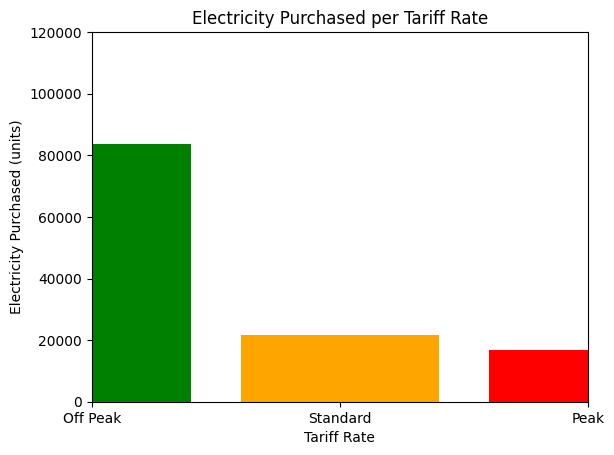

In [33]:
config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": 2760,
}

run = wandb.init(
    project="4022_intelligent_ems",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


eval_args = {
                "episode_len"   :2760,
                "actual_load"   :actual_load[6001:],
                "actual_gen"    :actual_gen[6001:],
                "bat_threshold" :100,
                "bat_cap"       :500,
                "purchase_price":purchase_price[6001:],
                "num_preds"     :24,
                "load_shedding" :load_shedding[6001:],
                "wandb_log"     : True,
                "train_log"     : False
}

#define 5 environments   for training and eval
n_envs = 5
eval_env = make_vec_env(EMS, n_envs = n_envs,env_kwargs = eval_args )


#first run it with only standby (default)
obs   = eval_env.reset()
#ensure that the exit condition is reset
done = [False]*n_envs
#define the action to take
action_standby = [0]*n_envs
#reset score
standby_score = [0]*n_envs
standby_score = np.array(standby_score).astype(np.float32)
while not all(done):
    #step the model with the action
    obs,reward,done,info = eval_env.step(action_standby)
    #accumulate the score
    standby_score += reward

avg_standby_score = standby_score.mean()

run.finish()

eval_args = {
                "episode_len"   :2760,
                "actual_load"   :actual_load[6001:],
                "actual_gen"    :actual_gen[6001:],
                "bat_threshold" :100,
                "bat_cap"       :500,
                "purchase_price":purchase_price[6001:],
                "num_preds"     :24,
                "load_shedding" :load_shedding[6001:],
                "wandb_log"     : True,
                "train_log"     : False
}

#define 5 environments   for training and eval
n_envs = 5
eval_env = make_vec_env(EMS, n_envs = n_envs,env_kwargs = eval_args )

#Load model, fetch the latest (or whichever one you want from the model_dir)
#Best A2C model:/content/drive/MyDrive/Colab Notebooks/EMSv1_1/models/A2C/EMSv1_1_A2C1010-081818.zip
best_model = "/content/drive/MyDrive/Colab Notebooks/EMSv1_1/models/A2C/EMSv1_1_A2C1010-081818.zip"
#best_model = "/content/drive/MyDrive/Colab Notebooks/EMSv1_1/models/DQN/EMSv1_1_DQN1010-082002.zip"
#best_PPO_model
model_load = f"{best_model}"

model  = A2C.load(model_load, env = eval_env)

run = wandb.init(
    project="4022_intelligent_ems",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)
obs   = eval_env.reset()
EMS_reward,EMS_std_reward = evaluate_policy(model,eval_env,n_eval_episodes = 1,deterministic=True)# callback = wandb_callback
run.finish()

print(f"Note: The term does not refer to the cost in rands but rather to the reward as defined by the reward function!")
print(f"Done the Standby Test! Total cost accumulated is: {avg_standby_score}")
print(f"Done applying the trained model! Total cost accumulated is: {EMS_reward} +- {EMS_std_reward}")

savings = EMS_reward - avg_standby_score
print(f"The amount that was saved by applying the EMS agent: {savings}")
print(f"This was saved over a period of {2760/24} days")
print(f"The savings represents {(savings/(-avg_standby_score))*100} % of the cost if no EMS is installed")
print(f"And it represents {(savings/(-EMS_reward))*100} % of the cost if the EMS is installed")
